In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

In [2]:
path = 'ray_results'
exps = os.listdir(path)

In [ ]:
dfs = []
for folder in exps:
    exp_folders = os.listdir(os.path.join(path, folder))
    for expsf in exp_folders:
        try:
            files = os.listdir(os.path.join(path, folder, expsf))
            file_path = os.path.join(path, folder, expsf, 'result.json')
            with open(file_path, "r") as f:
                data = json.load(f)
            df = pd.json_normalize(data)
            dfs.append(df)
        except:
            "Not a folder"
results = pd.concat(dfs)
results.to_csv('results_he_ransom_ccka.csv')

In [32]:
results.columns

Index(['num_layers', 'accuracy_train_init', 'accuracy_test_init',
       'alignment_train_init', 'accuracy_train_final', 'accuracy_test_final',
       'alignment_train_epochs', 'circuit_executions', 'timestamp',
       'checkpoint_dir_name', 'done', 'training_iteration', 'trial_id', 'date',
       'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'iterations_since_restore', 'config.name',
       'config.file', 'config.n_samples', 'config.noise', 'config.num_sectors',
       'config.points_per_sector', 'config.grid_size',
       'config.sampling_radius', 'config.training_size', 'config.testing_size',
       'config.validation_size', 'config.device', 'config.n_qubits',
       'config.trainable', 'config.input_scaling', 'config.data_reuploading',
       'config.ansatz', 'config.ansatz_layers', 'config.optimizer',
       'config.lr', 'config.epochs', 'config.train_method',
       'config.target_accuracy', 'config.get_alignment_every',
       'co

##**Initial Accuracy vs Final Accuracy**

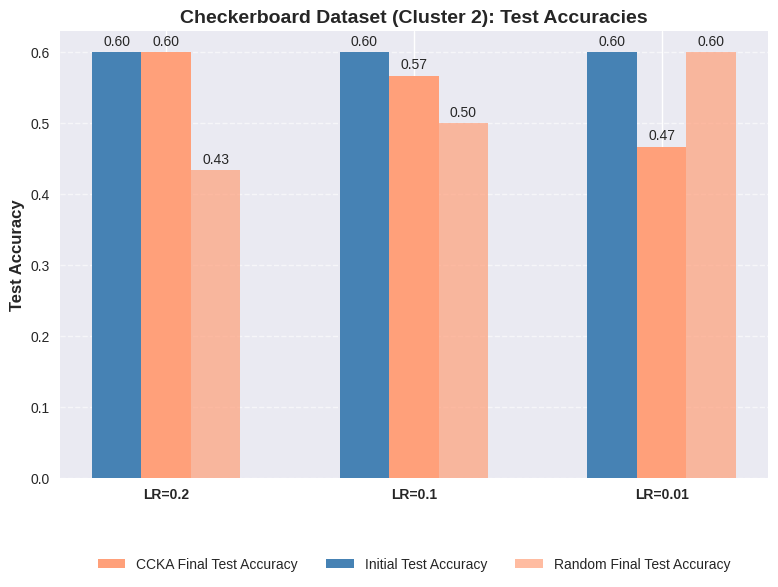

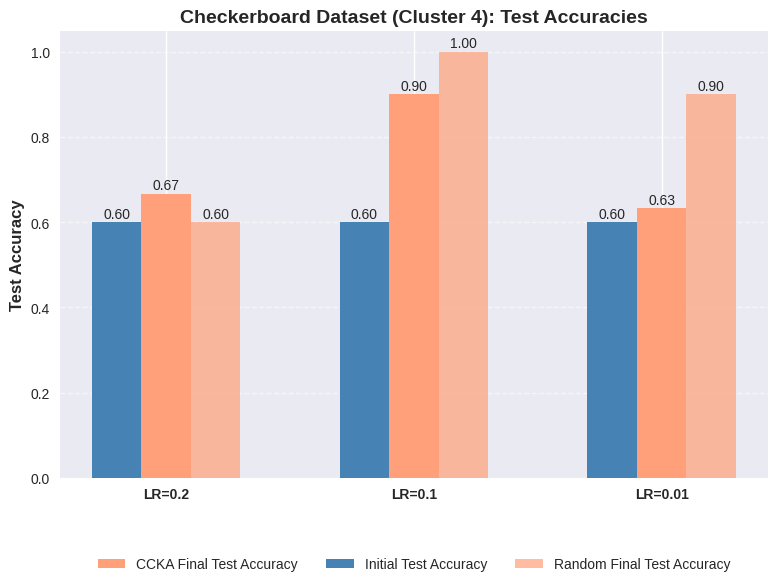

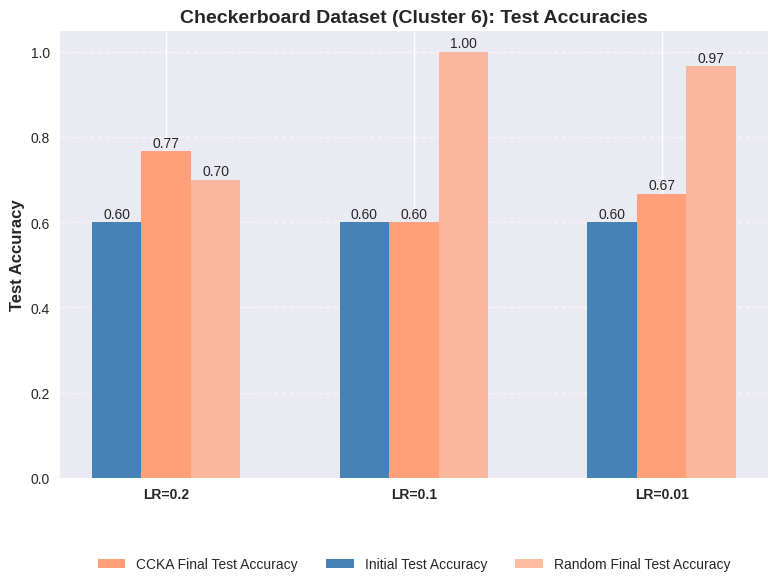

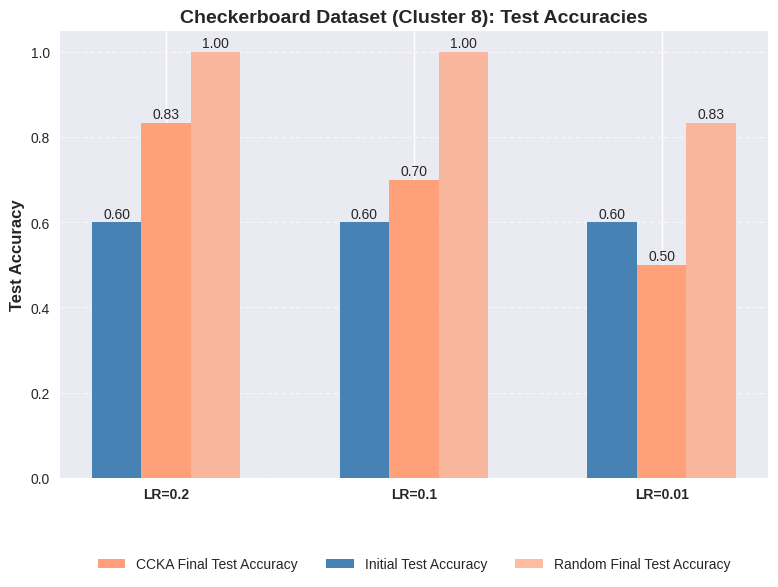

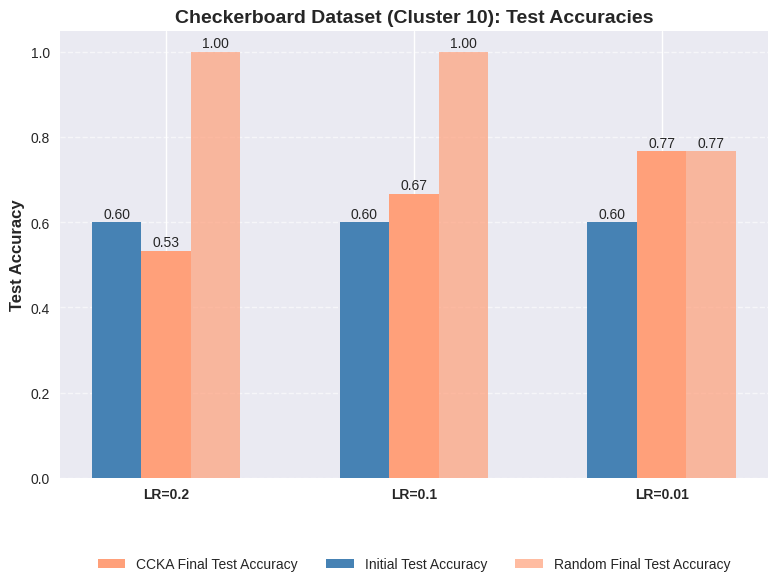

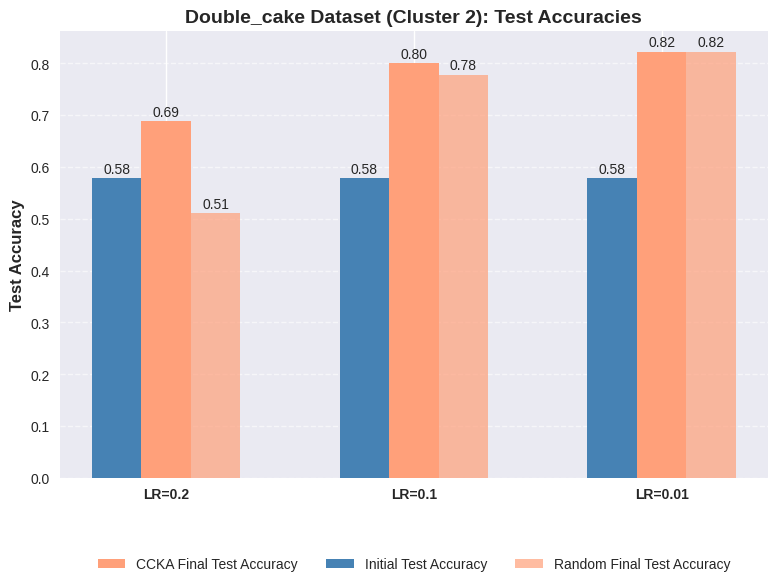

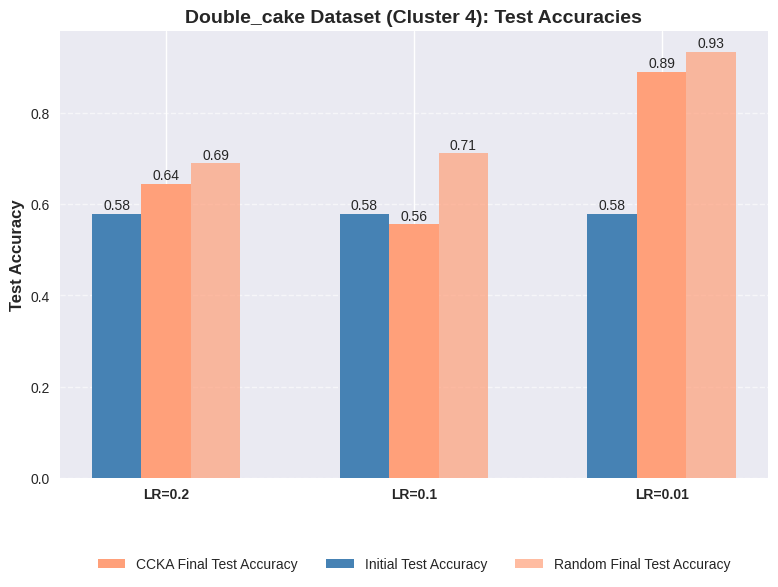

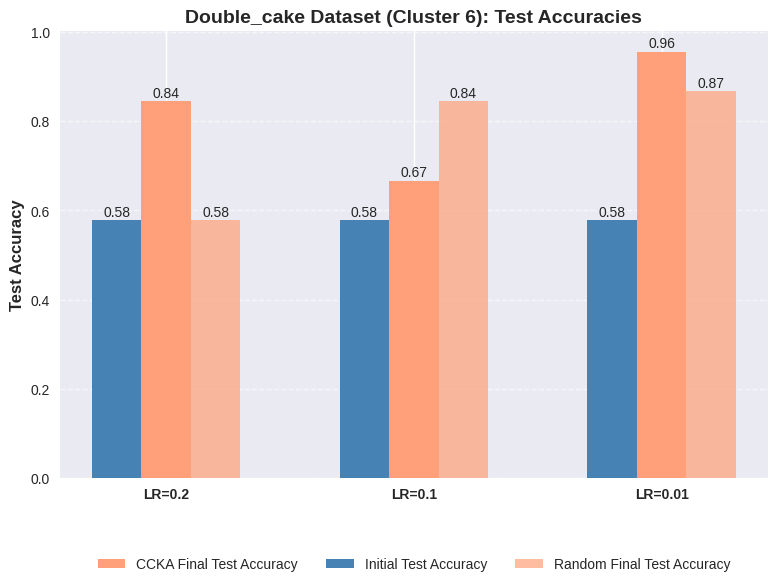

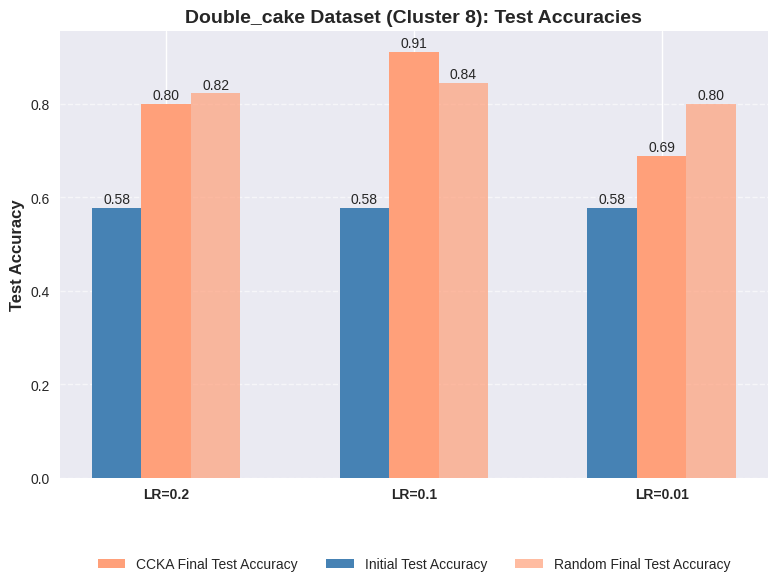

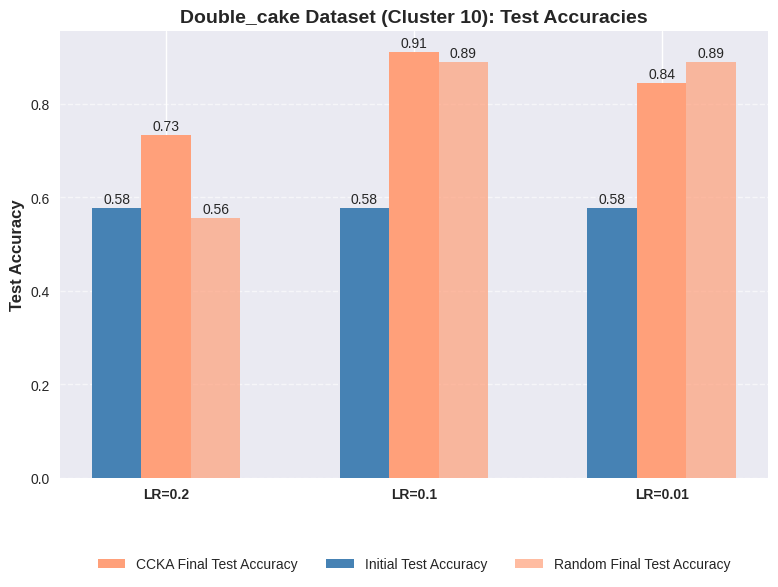

In [62]:
def plot_cluster_comparison(df):
    plt.style.use('seaborn-v0_8')
    datasets = df['config.name'].unique()

    # Define the specific colors
    final_color = '#ffa07a'  # Salmon orange
    initial_color = '#4682b4'  # Light blue for initial accuracy

    for dataset in datasets:
        # Filter data for the specific dataset
        dataset_data = df[df['config.name'] == dataset]

        # Get unique clusters for the dataset
        clusters = [2, 4, 6, 8, 10]  # dataset_data['config.clusters'].unique()

        for cluster in clusters:
            fig, ax = plt.subplots(figsize=(8, 6))

            # Filter data for the specific cluster
            filtered_data = dataset_data[dataset_data['config.clusters'] == cluster]

            # Separate CCKA and Random methods
            ccka_data = filtered_data[filtered_data['config.train_method'] == 'ccka']
            random_data = filtered_data[filtered_data['config.train_method'] == 'random']

            # Extract unique learning rates
            x_labels = [0.2, 0.1, 0.01]  # filtered_data['config.lr'].unique()

            # Ensure data is aligned with x_labels
            ccka_final_accuracies = [ccka_data[ccka_data['config.lr'] == lr]['accuracy_test_final'].mean() for lr in x_labels]
            ccka_initial_accuracies = [ccka_data[ccka_data['config.lr'] == lr]['accuracy_test_init'].mean() for lr in x_labels]
            random_final_accuracies = [random_data[random_data['config.lr'] == lr]['accuracy_test_final'].mean() for lr in x_labels]

            # Bar positions
            x_positions = range(len(x_labels))

            # Plot bars for CCKA
            ax.bar(x_positions, ccka_final_accuracies, width=0.2, color=final_color, label='CCKA Final Test Accuracy')
            ax.bar([pos - 0.2 for pos in x_positions], ccka_initial_accuracies, width=0.2, color=initial_color, label='Initial Test Accuracy')

            # Plot bars for Random
            ax.bar([pos + 0.2 for pos in x_positions], random_final_accuracies, width=0.2, color=final_color, alpha=0.7, label='Random Final Test Accuracy')

            # Set labels and title
            ax.set_xticks(x_positions)
            ax.set_xticklabels([f"LR={lr}" for lr in x_labels], fontsize=10, fontweight='bold')
            ax.set_ylabel("Test Accuracy", fontsize=12, fontweight='bold')
            ax.set_title(f"{dataset.capitalize()} Dataset (Cluster {cluster}): Test Accuracies", fontsize=14, fontweight='bold')

            # Adding values above bars
            for x, value in zip(x_positions, ccka_final_accuracies):
                ax.text(x, value + 0.01, f'{value:.2f}', ha='center', fontsize=10)
            for x, value in zip([pos - 0.2 for pos in x_positions], ccka_initial_accuracies):
                ax.text(x, value + 0.01, f'{value:.2f}', ha='center', fontsize=10)
            for x, value in zip([pos + 0.2 for pos in x_positions], random_final_accuracies):
                ax.text(x, value + 0.01, f'{value:.2f}', ha='center', fontsize=10)

            # Customize grid and legend
            ax.grid(axis='y', linestyle='--', alpha=0.6)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            # Position the legend outside the plot
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)

            plt.tight_layout()
            plt.show()

# Plot separate charts for each cluster
acc = results[['accuracy_train_init', 'accuracy_test_init', 'accuracy_train_final', 'accuracy_test_final', 'config.name', 'config.lr', 'config.train_method', 'config.clusters']]
plot_cluster_comparison(acc)

**Alignment Plot**

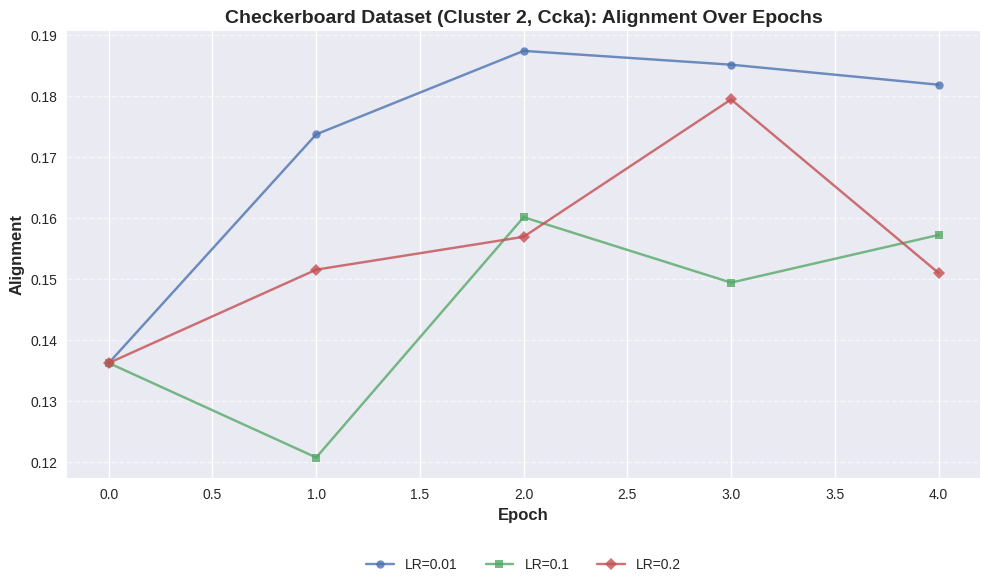

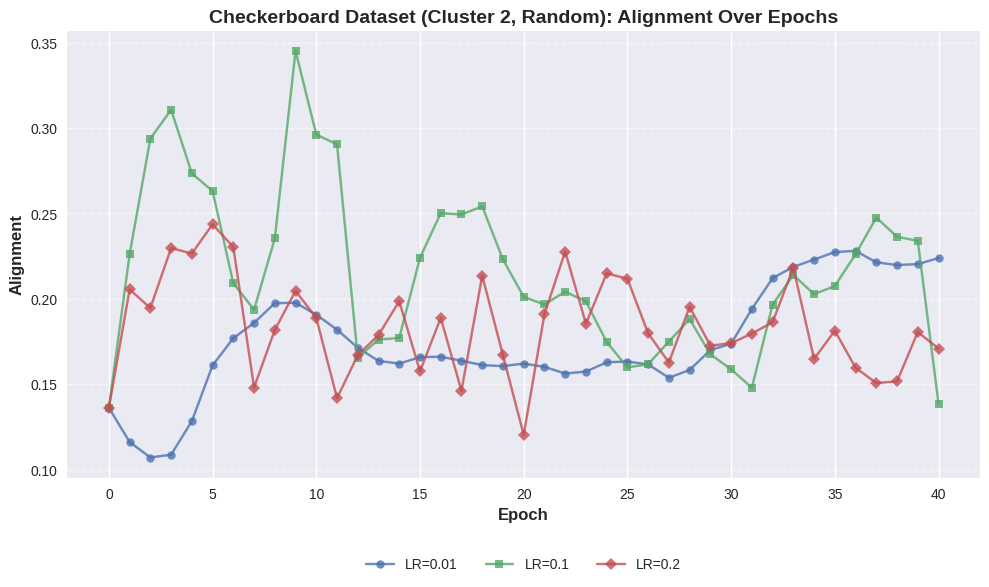

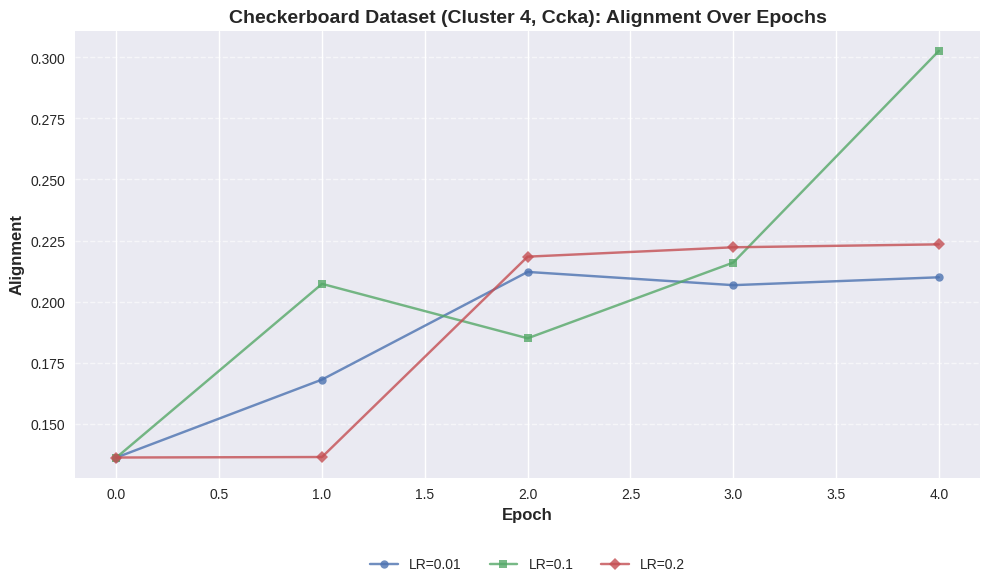

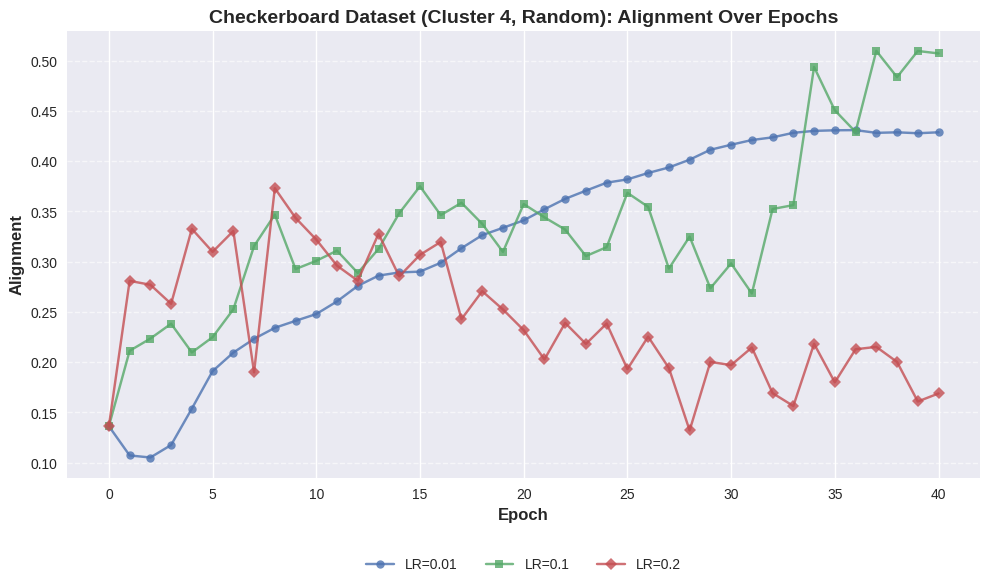

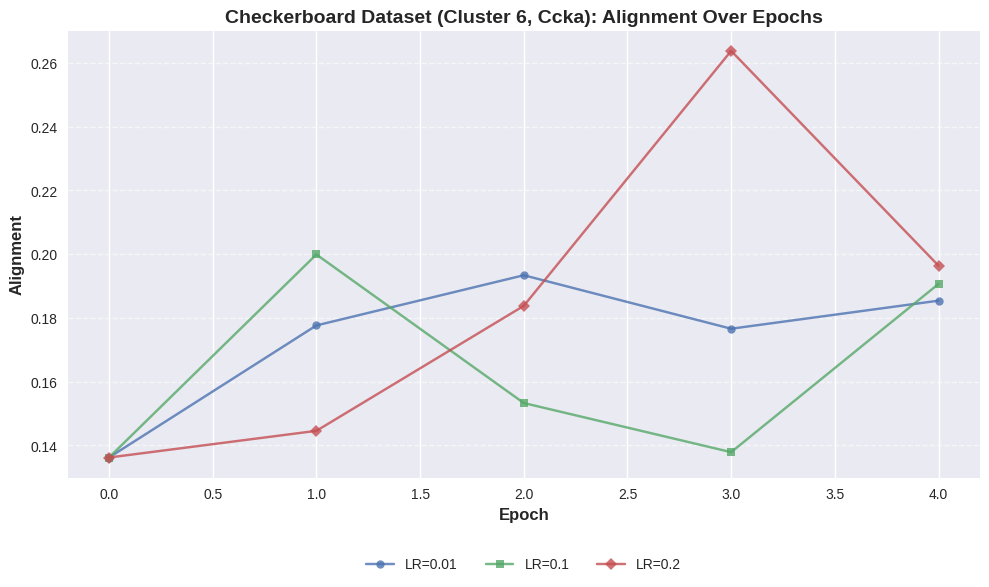

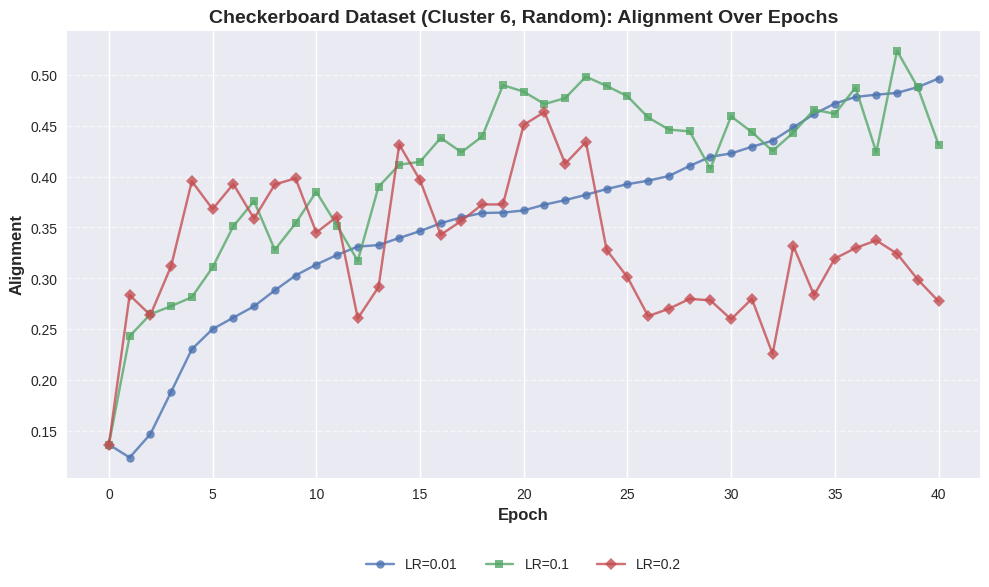

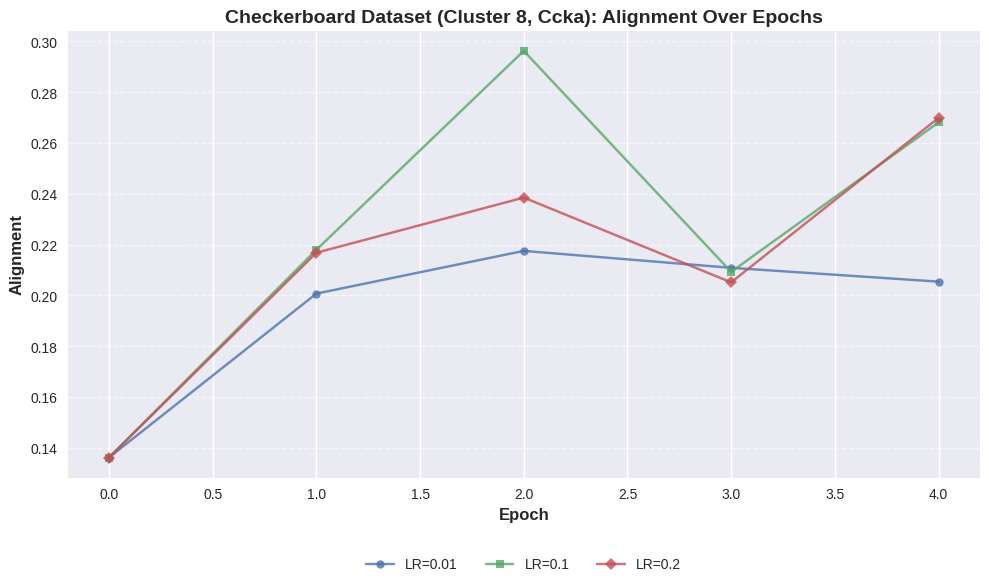

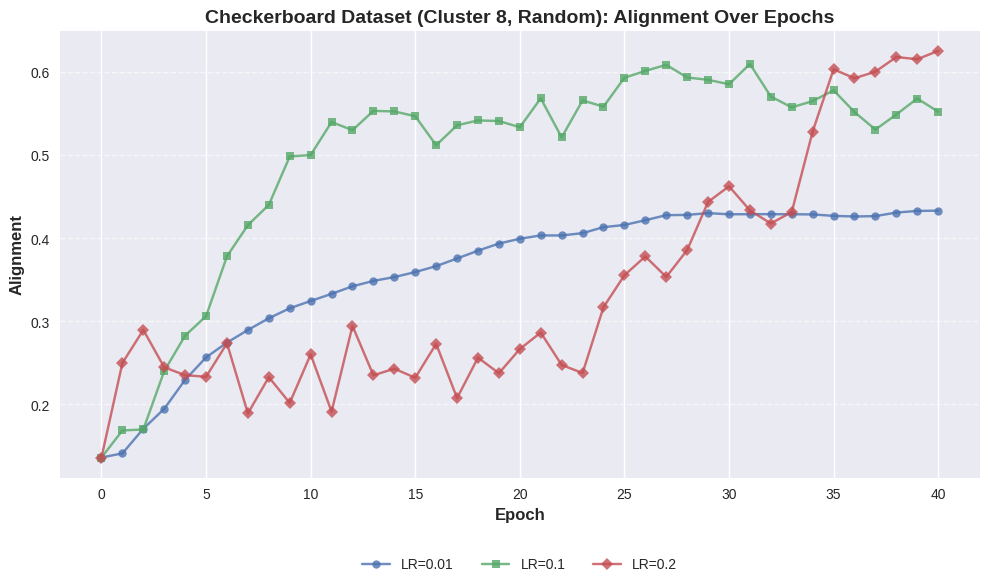

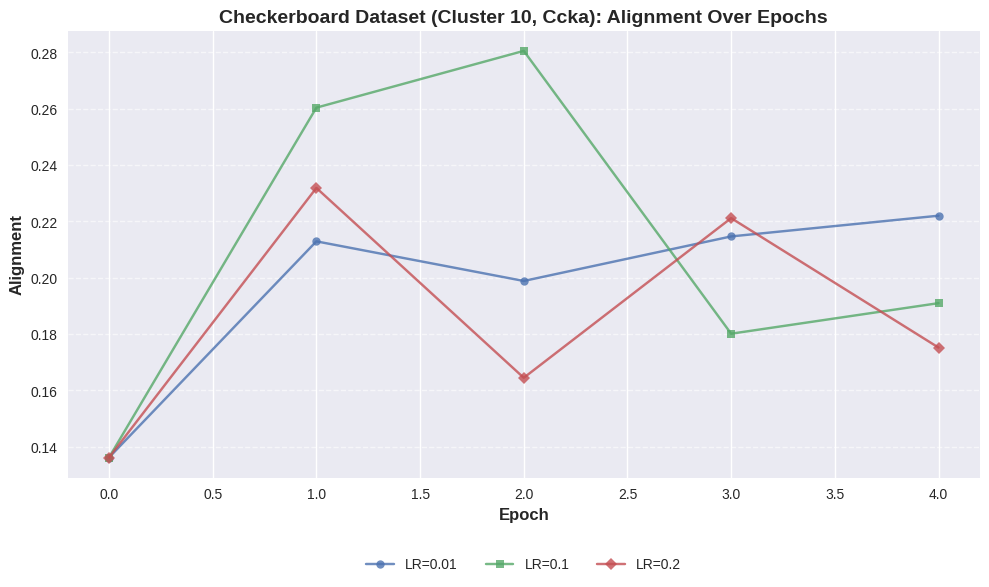

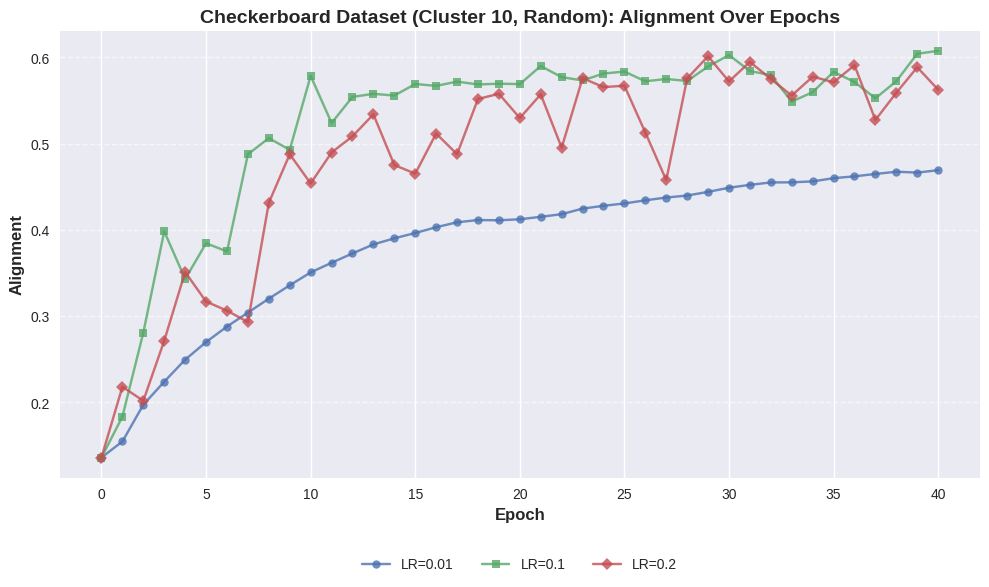

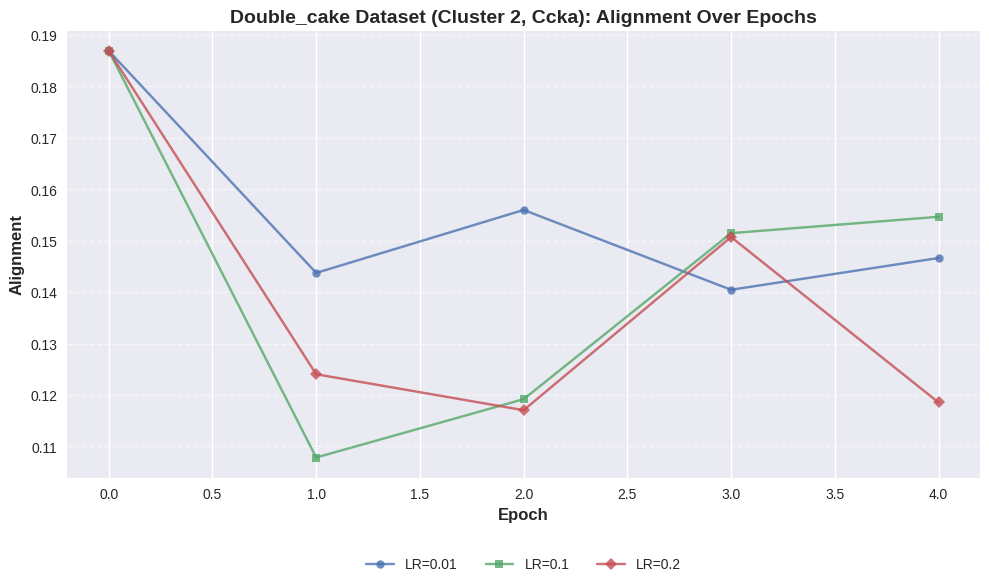

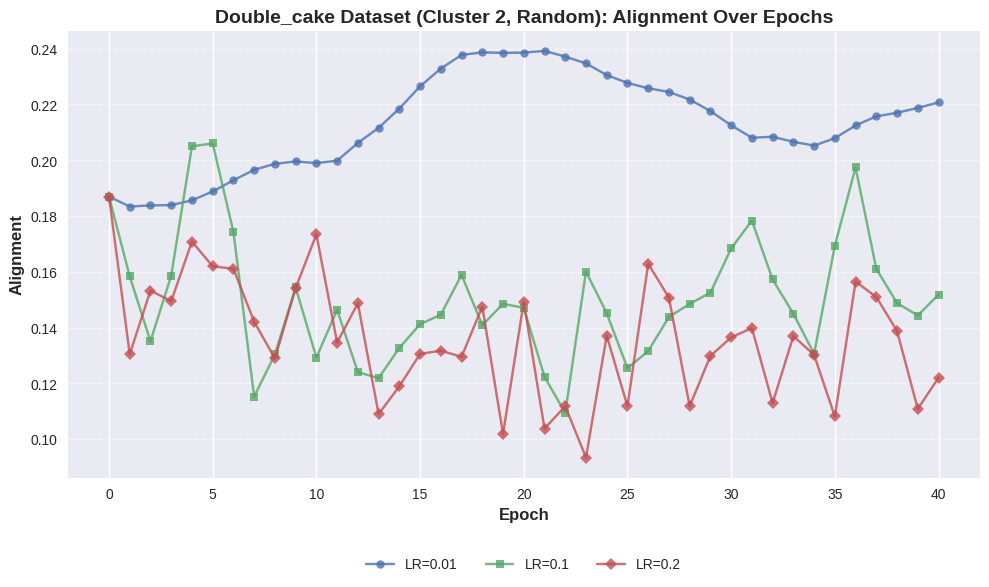

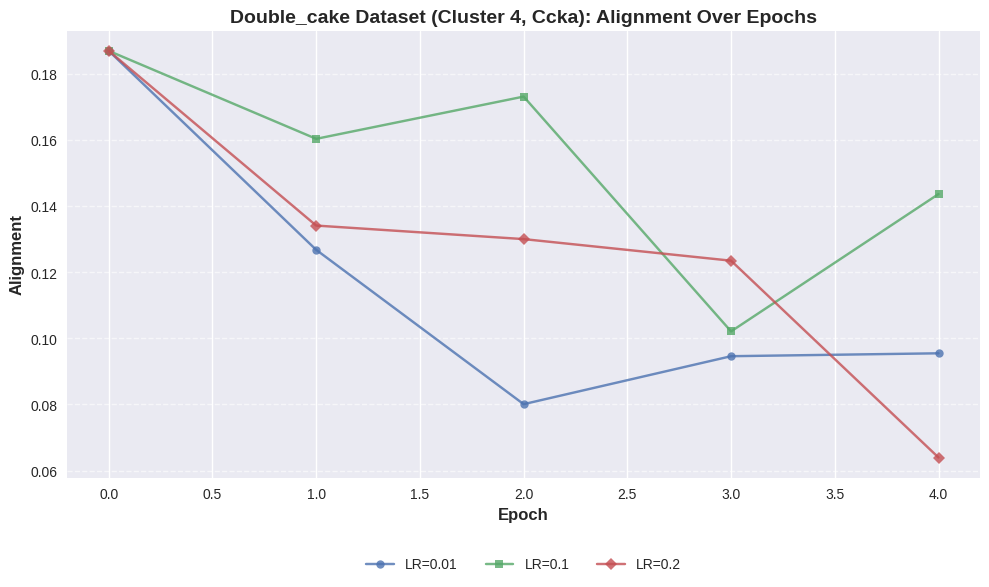

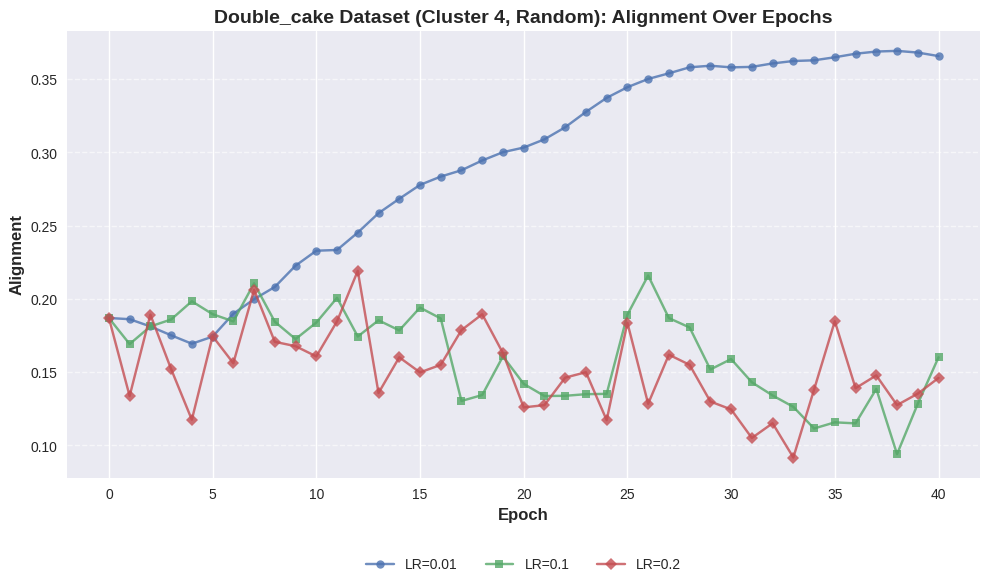

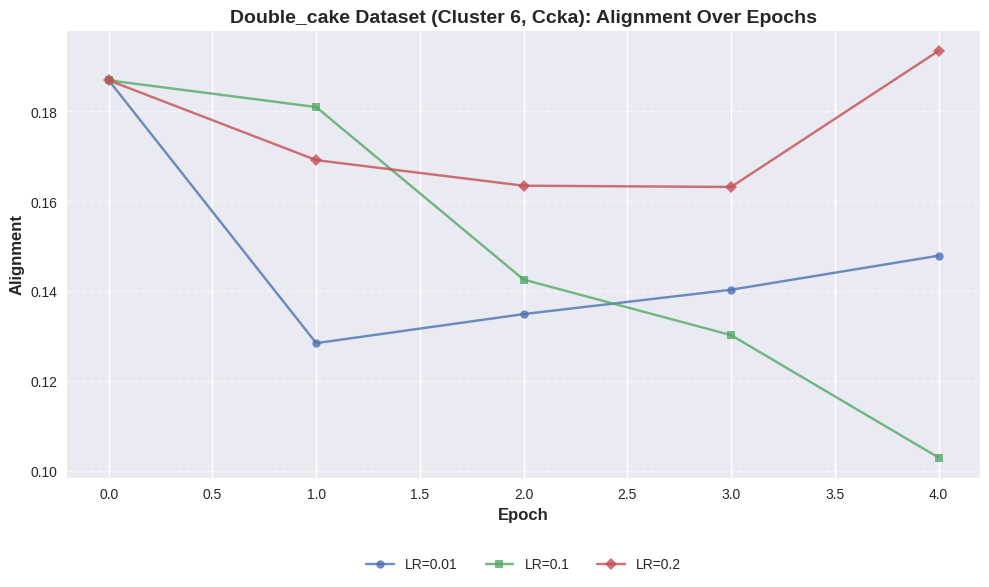

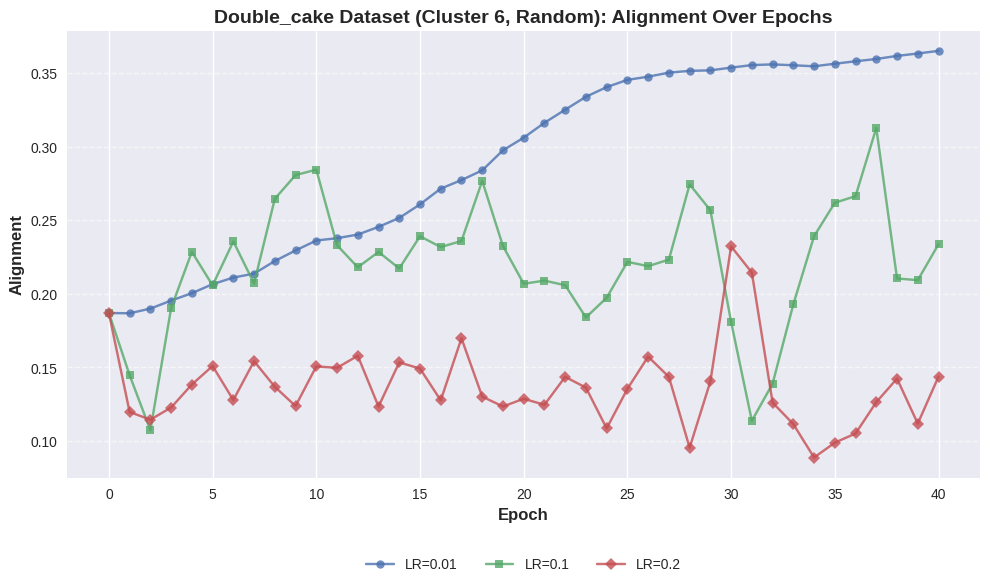

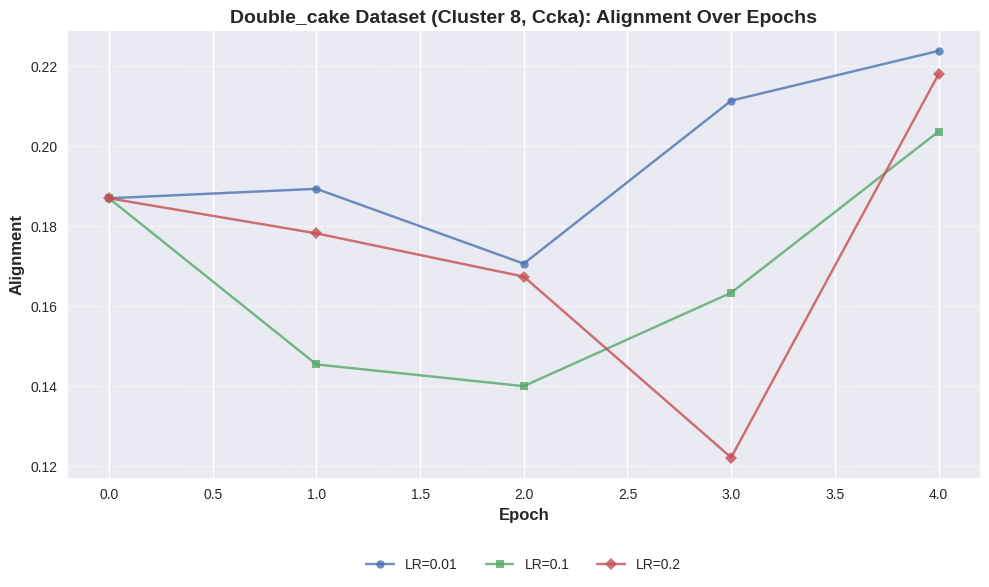

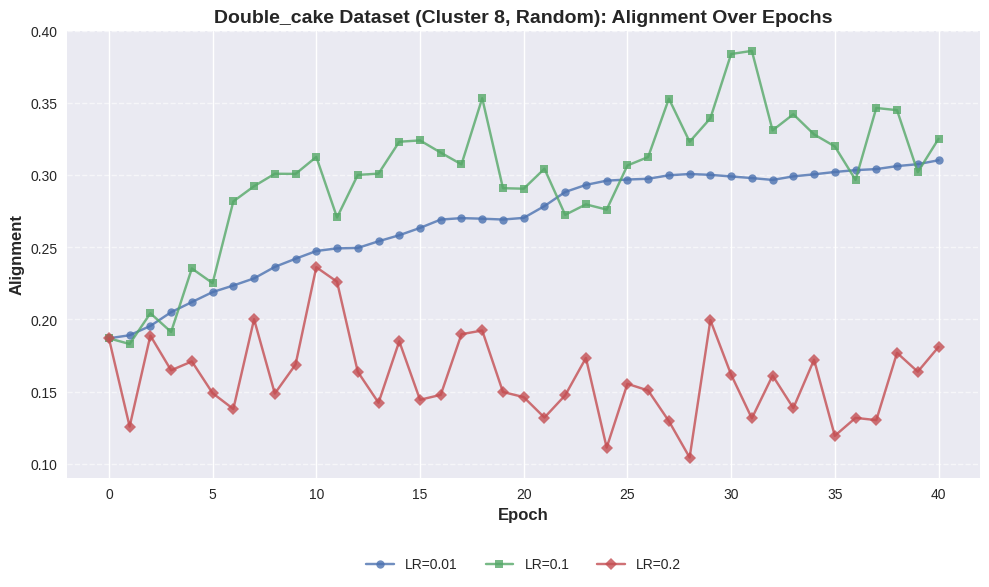

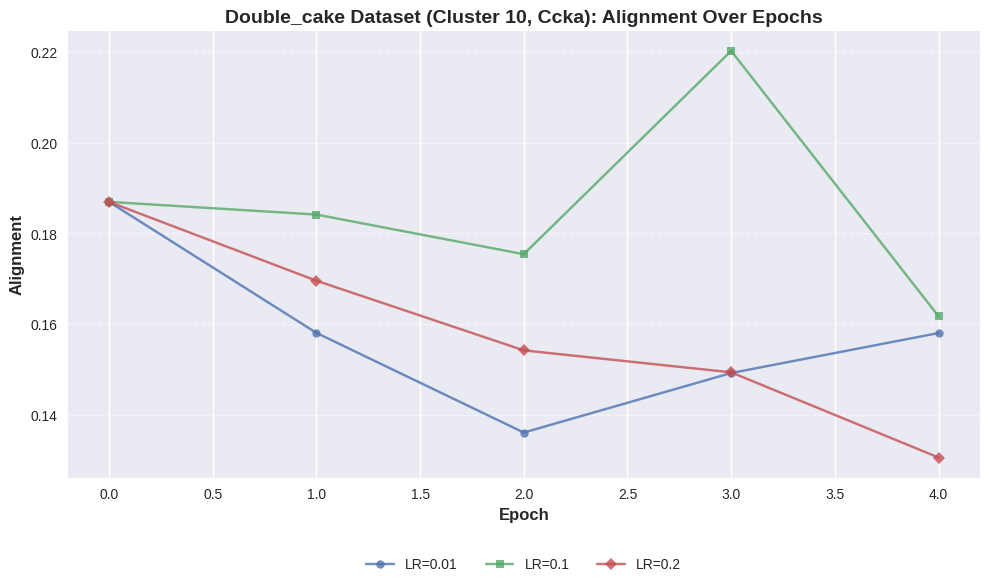

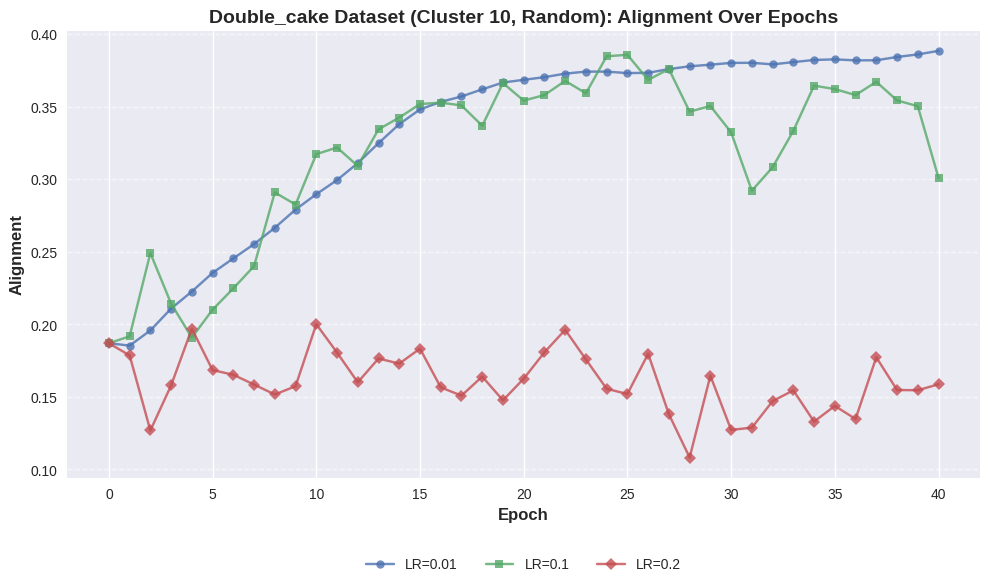

In [78]:
def plot_separate_alignment_charts(df):
    plt.style.use('seaborn-v0_8')
    datasets = df['config.name'].unique()

    for dataset in datasets:
        # Filter data for the specific dataset
        dataset_data = df[df['config.name'] == dataset]

        # Get unique clusters for the dataset
        clusters = [2, 4, 6, 8, 10]#dataset_data['config.clusters'].unique()

        for cluster in clusters:
            for method in ['ccka', 'random']:
                # Filter data for the specific method and cluster
                method_data = dataset_data[
                    (dataset_data['config.train_method'] == method) &
                    (dataset_data['config.clusters'] == cluster)
                ]

                if method_data.empty:
                    continue  # Skip if no data for this combination

                fig, ax = plt.subplots(figsize=(10, 6))

                # Plot for each learning rate
                learning_rates = [0.01, 0.1, 0.2]#method_data['config.lr'].unique()
                markers = ['o', 's', 'D', '^', 'v']  # Marker styles for lines
                for i, lr in enumerate(learning_rates):
                    lr_data = method_data[method_data['config.lr'] == lr]

                    # Combine alignment_train_init with alignment_train_epochs
                    alignments = []
                    if not lr_data.empty:
                        alignments.append(lr_data['alignment_train_init'].iloc[0])
                        for epoch_alignments in lr_data['alignment_train_epochs']:
                            alignments.extend(epoch_alignments)
                            break

                    # Plot alignment over epochs with markers
                    ax.plot(
                        range(len(alignments)),
                        alignments,
                        label=f"LR={lr}",
                        alpha=0.8,
                        marker=markers[i % len(markers)],  # Cycle through markers
                        markersize=6  # Adjust marker size
                    )

                # Set labels and title
                ax.set_xlabel("Epoch", fontsize=12, fontweight='bold')
                ax.set_ylabel("Alignment", fontsize=12, fontweight='bold')
                ax.set_title(
                    f"{dataset.capitalize()} Dataset (Cluster {cluster}, {method.capitalize()}): Alignment Over Epochs",
                    fontsize=14,
                    fontweight='bold'
                )

                # Customize grid and legend
                ax.grid(axis='y', linestyle='--', alpha=0.6)
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)

                # Position the legend outside the plot
                ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)

                plt.tight_layout()
                plt.show()

# Prepare data for the plot
align = results[['alignment_train_init', 'alignment_train_epochs', 'config.name', 'config.lr', 'config.train_method', 'config.clusters']]

# Plot the alignment line chart
plot_separate_alignment_charts(align)


***Circuit Executions***

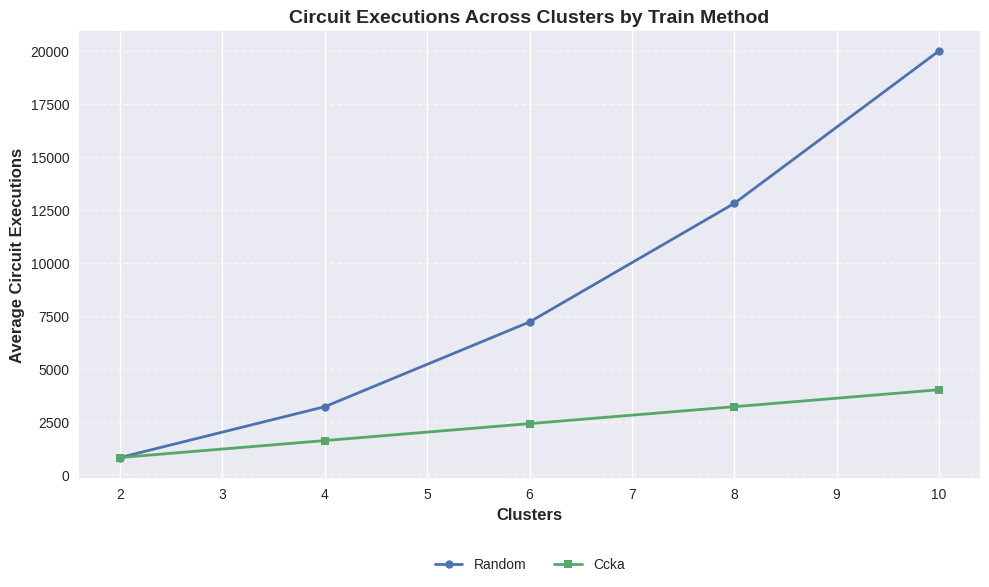

In [79]:
import matplotlib.pyplot as plt

def plot_circuit_executions(df):
    plt.style.use('seaborn-v0_8')

    # Get unique train methods and clusters
    train_methods = df['config.train_method'].unique()
    clusters = sorted(df['config.clusters'].unique())

    fig, ax = plt.subplots(figsize=(10, 6))

    # Define markers for better visualization
    markers = ['o', 's', 'D', '^', 'v']

    for i, method in enumerate(train_methods):
        # Filter data for each training method
        method_data = df[df['config.train_method'] == method]

        # Get average circuit executions for each cluster
        avg_executions = [
            method_data[method_data['config.clusters'] == cluster]['circuit_executions'].mean()
            for cluster in clusters
        ]

        # Plot the line for the current training method
        ax.plot(
            clusters,
            avg_executions,
            label=f"{method.capitalize()}",
            marker=markers[i % len(markers)],
            markersize=6,
            linewidth=2
        )

    # Set labels and title
    ax.set_xlabel("Clusters", fontsize=12, fontweight='bold')
    ax.set_ylabel("Average Circuit Executions", fontsize=12, fontweight='bold')
    ax.set_title("Circuit Executions Across Clusters by Train Method", fontsize=14, fontweight='bold')

    # Customize grid and legend
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Position the legend
    #ax.legend(loc='upper right', fontsize=10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)
    plt.tight_layout()
    plt.show()

# Prepare data for the plot
executions = results[['circuit_executions', 'config.train_method', 'config.clusters']]

# Plot the circuit executions
plot_circuit_executions(executions)